In [1]:
import tensorflow as tf
import numpy as np
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

from tensorflow import keras

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# 01. ResNet 기본 블록 구성

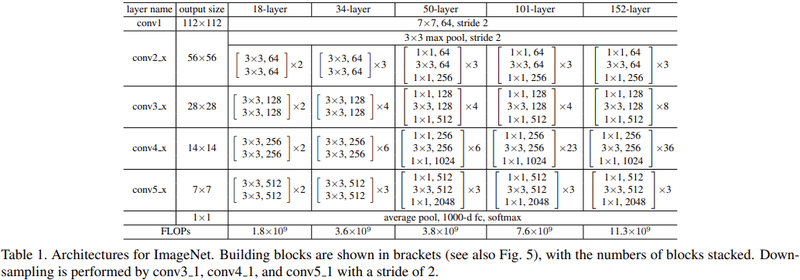

In [3]:
def build_res34_block(input_layer,
                   num_cnn=3,
                   channel=64,
                   block_num=1,
                   shortCut=None,
                   is_plain=False
                   ):
    
    # 입력 레이어
    x = input_layer
    
    # CNN 레이어
    for cnn_num in range(num_cnn):

        shortCut_channel=shortCut.shape.as_list()[-1]
        x = keras.layers.Conv2D(filters=channel,
                                        kernel_size=(3,3),
                                        padding='same',
                                        name=f'block{block_num}_{cnn_num}_conv1'
                                       )(x)
        x = keras.layers.BatchNormalization(name=f'block{block_num}_{cnn_num}_bn1')(x)
        x = keras.layers.Activation('relu',name=f'block{block_num}_{cnn_num}_act1')(x)
        x = keras.layers.Conv2D(filters=channel,
                                        kernel_size=(3,3),
                                        padding='same',
                                        name=f'block{block_num}_{cnn_num}_conv2'
                                       )(x)
        x = keras.layers.BatchNormalization(name=f'block{block_num}_{cnn_num}_bn2')(x)
        
        if not is_plain:
            if shortCut_channel != channel:
                shortCut = keras.layers.Conv2D(channel, (1,1), padding='same',name=f'block{block_num}_short_conv')(shortCut)
                shortCut = keras.layers.BatchNormalization(name=f'block{block_num}_short_bn')(shortCut)

            x = keras.layers.Add()([x,shortCut])
        x = keras.layers.Activation('relu')(x)
        shortCut=x
            
    return x

In [4]:
def build_res_block(input_layer,
                   num_cnn=3,
                   channel=64,
                   block_num=1,
                   shortCut=None,
                   is_plain=False
                   ):
    
    # 입력 레이어
    x = input_layer
    
    # CNN 레이어
    for cnn_num in range(num_cnn):
        shortCut_channel=shortCut.shape.as_list()[-1]
        
        # 1x1
        x = keras.layers.Conv2D(filters=channel,
                                        kernel_size=(1,1),
                                        padding='same',
                                        name=f'block{block_num}_{cnn_num}_conv1'
                                        )(x)
        x = keras.layers.BatchNormalization(name=f'block{block_num}_{cnn_num}_bn1')(x)
        x = keras.layers.Activation('relu',name=f'block{block_num}_{cnn_num}_act1')(x)
        
        # 3x3
        x = keras.layers.Conv2D(filters=channel,
                                        kernel_size=(3,3),
                                        padding='same',
                                        name=f'block{block_num}_{cnn_num}_conv2'
                                        )(x)
        x = keras.layers.BatchNormalization(name=f'block{block_num}_{cnn_num}_bn2')(x)
        x = keras.layers.Activation('relu',name=f'block{block_num}_{cnn_num}_act2')(x)
        
        # 1x1
        x = keras.layers.Conv2D(filters=channel*4,
                                        kernel_size=(1,1),
                                        padding='same',
                                        name=f'block{block_num}_{cnn_num}_conv3'
                                        )(x)
        x = keras.layers.BatchNormalization(name=f'block{block_num}_{cnn_num}_bn3')(x)
         
        if not is_plain:
            if shortCut_channel != channel*4:       
                shortCut = keras.layers.Conv2D(channel*4, (1,1), padding='same',name=f'block{block_num}_short_conv')(shortCut)
                shortCut = keras.layers.BatchNormalization(name=f'block{block_num}_short_bn')(shortCut)    

            x = keras.layers.Add()([x,shortCut])
        x = keras.layers.Activation('relu')(x)
        shortCut=x
    
    return x

In [5]:
def build_res_plain(input_shape=(224,224,3),
             num_cnn_list=[3,4,6,3],
             channel_list=[64,128,256,512],
             num_classes=2,
             is_34=True,
             is_plain=False
             ):
    
    # 모델을 만들기 전에 config list들이 같은 길이인지 확인
    assert len(num_cnn_list) == len(channel_list)
    
    
    input_layer = keras.layers.Input(shape=input_shape)  # input layer 생성
    output = input_layer
    
    # Conv1
    output = keras.layers.Conv2D(
                            filters=64, 
                            kernel_size=(7,7),
                            strides=2,
                            padding='same', 
                            kernel_initializer='he_normal',
                            name='block1_conv'
                            )(output)
    output = keras.layers.BatchNormalization(name=f'block1_bn')(output)
    output = keras.layers.Activation('relu',name=f'block1_act')(output)
    
    # Max Pooling
    output = keras.layers.MaxPooling2D((3,3), 2, padding='same')(output)
    
    shortCut=output
    
    # config list들의 길이만큼 반복해서 블록 생성
    if is_34 :
        for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
            output = build_res34_block(
                output,
                num_cnn=num_cnn,
                channel=channel,
                block_num=i+2,
                shortCut=shortCut,
                is_plain=is_plain
                 )
            shortCut = output
    else:
        for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
            output = build_res_block(
                output,
                num_cnn=num_cnn,
                channel=channel,
                block_num=i+2,
                shortCut=shortCut,
                is_plain=is_plain
                )
            shortCut = output
    
    output = keras.layers.GlobalAveragePooling2D()(output)
    output = keras.layers.Flatten()(output)
    output = keras.layers.Dense(1000, activation='relu')(output)
    output = keras.layers.Dense(2, activation='softmax')(output)


    model = keras.Model(
        inputs = input_layer,
        outputs = output)
    
    return model

# 02. ResNet-34, ResNet-50 Complete Model

In [6]:
res_34 = build_res_plain(input_shape=(224,224,3), is_34=True)

res_34.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv (Conv2D)            (None, 112, 112, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
block1_bn (BatchNormalization)  (None, 112, 112, 64) 256         block1_conv[0][0]                
__________________________________________________________________________________________________
block1_act (Activation)         (None, 112, 112, 64) 0           block1_bn[0][0]                  
______________________________________________________________________________________________

In [7]:
res_50 = build_res_plain(input_shape=(224,224,3), is_34=False)

res_50.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv (Conv2D)            (None, 112, 112, 64) 9472        input_2[0][0]                    
__________________________________________________________________________________________________
block1_bn (BatchNormalization)  (None, 112, 112, 64) 256         block1_conv[0][0]                
__________________________________________________________________________________________________
block1_act (Activation)         (None, 112, 112, 64) 0           block1_bn[0][0]                  
____________________________________________________________________________________________

# 03. 일반 네트워크(plain network)

In [8]:
plain_34 = build_res_plain(input_shape=(224,224,3), is_34=True, is_plain=True)
plain_34.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv (Conv2D)         (None, 112, 112, 64)      9472      
_________________________________________________________________
block1_bn (BatchNormalizatio (None, 112, 112, 64)      256       
_________________________________________________________________
block1_act (Activation)      (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
block2_0_conv1 (Conv2D)      (None, 56, 56, 64)        36928     
_________________________________________________________________
block2_0_bn1 (BatchNormaliza (None, 56, 56, 64)        256 

In [9]:
plain_50 = build_res_plain(input_shape=(224,224,3), is_34=False, is_plain=True)
plain_50.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv (Conv2D)         (None, 112, 112, 64)      9472      
_________________________________________________________________
block1_bn (BatchNormalizatio (None, 112, 112, 64)      256       
_________________________________________________________________
block1_act (Activation)      (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
block2_0_conv1 (Conv2D)      (None, 56, 56, 64)        4160      
_________________________________________________________________
block2_0_bn1 (BatchNormaliza (None, 56, 56, 64)        256 

# 04. Data Load

In [21]:
import os


_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
file_name=os.getenv('HOME')+'/aiffel/cats_dogs/cats_and_dogs.zip'
path_to_zip = tf.keras.utils.get_file(file_name, origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')
PATH

68616192/68606236 [==============================] - 0s 0us/step


'/aiffel/aiffel/cats_dogs/cats_and_dogs_filtered'

In [28]:
cat_path = PATH + '/train/cats/'
dog_path = PATH + '/train/dogs/'
cat_val_path = PATH + '/validation/cats/'
dog_val_path = PATH + '/validation/dogs/'

print("number of cat train examples :", len(os.listdir(cat_path)))
print("number of dog train examples :", len(os.listdir(dog_path)))
print("number of cat validation examples :", len(os.listdir(cat_val_path)))
print("number of dog validation examples :", len(os.listdir(dog_val_path)))

number of cat train examples : 1000
number of dog train examples : 1000
number of cat validation examples : 500
number of dog validation examples : 500


In [36]:
total_train_num = len(os.listdir(cat_path))+len(os.listdir(dog_path))
total_val_num = len(os.listdir(cat_val_path))+len(os.listdir(dog_val_path))

In [31]:
# 이미지 크기 확인
f = cat_path + os.listdir(cat_path)[1]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

f = dog_path + os.listdir(dog_path)[1]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(400, 399, 3)
(233, 350, 3)


이미지 크기가 다 다름

In [82]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 16
epochs = 25
IMG_HEIGHT = 224
IMG_WIDTH = 224

train_image_generator = ImageDataGenerator(rescale=1./255)
validation_image_generator = ImageDataGenerator(rescale=1./255)

train_dir = PATH + '/train/'
val_dir = PATH + '/validation/'

train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='binary')
val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=val_dir,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


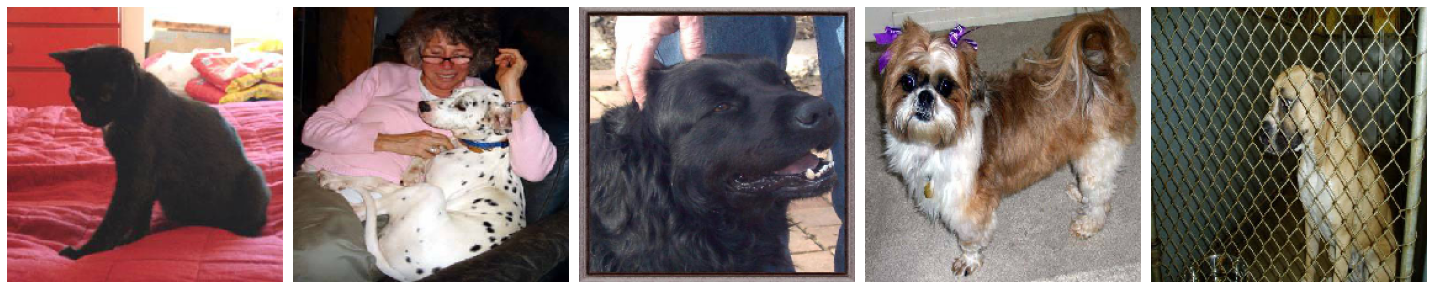

In [77]:
# 데이터 확인
sample_training_images, _ = next(train_data_gen)

def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    
plotImages(sample_training_images[:5])

# 04. ResNet-34 vs Plain-34

In [78]:
# ResNet-34
res_34.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9),
    metrics=['accuracy'])

history_res34 = res_34.fit(
    train_data_gen,
    epochs=epochs,
    validation_data=val_data_gen)


Epoch 1/25
63/63 [==============================] - 113s 2s/step - loss: 0.2624 - accuracy: 0.8915 - val_loss: 1.0102 - val_accuracy: 0.6520
Epoch 2/25
63/63 [==============================] - 110s 2s/step - loss: 0.2815 - accuracy: 0.8855 - val_loss: 1.4357 - val_accuracy: 0.5840
Epoch 3/25
63/63 [==============================] - 110s 2s/step - loss: 0.2805 - accuracy: 0.8815 - val_loss: 1.9724 - val_accuracy: 0.5740
Epoch 4/25
63/63 [==============================] - 109s 2s/step - loss: 0.2192 - accuracy: 0.9130 - val_loss: 0.8196 - val_accuracy: 0.6910
Epoch 5/25
63/63 [==============================] - 110s 2s/step - loss: 0.1774 - accuracy: 0.9310 - val_loss: 3.3174 - val_accuracy: 0.5200
Epoch 6/25
63/63 [==============================] - 110s 2s/step - loss: 0.1753 - accuracy: 0.9315 - val_loss: 5.1676 - val_accuracy: 0.5280
Epoch 7/25
63/63 [==============================] - 110s 2s/step - loss: 0.1739 - accuracy: 0.9385 - val_loss: 2.6836 - val_accuracy: 0.5410
Epoch 8/25
63

In [79]:
# Plain-34

plain_34.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9),
    metrics=['accuracy'])

history_plain34 = plain_34.fit(
    train_data_gen,
    epochs=epochs,
    validation_data=val_data_gen)


Epoch 1/25
63/63 [==============================] - 106s 2s/step - loss: 0.3809 - accuracy: 0.8290 - val_loss: 0.8513 - val_accuracy: 0.7000
Epoch 2/25
63/63 [==============================] - 104s 2s/step - loss: 0.3809 - accuracy: 0.8310 - val_loss: 1.9348 - val_accuracy: 0.6070
Epoch 3/25
63/63 [==============================] - 104s 2s/step - loss: 0.3558 - accuracy: 0.8455 - val_loss: 1.7839 - val_accuracy: 0.5720
Epoch 4/25
63/63 [==============================] - 104s 2s/step - loss: 0.2967 - accuracy: 0.8730 - val_loss: 0.8016 - val_accuracy: 0.7100
Epoch 5/25
63/63 [==============================] - 103s 2s/step - loss: 0.3075 - accuracy: 0.8765 - val_loss: 0.7667 - val_accuracy: 0.7010
Epoch 6/25
63/63 [==============================] - 103s 2s/step - loss: 0.2616 - accuracy: 0.9015 - val_loss: 3.4960 - val_accuracy: 0.5560
Epoch 7/25
63/63 [==============================] - 103s 2s/step - loss: 0.2943 - accuracy: 0.8805 - val_loss: 0.8911 - val_accuracy: 0.7010
Epoch 8/25
63

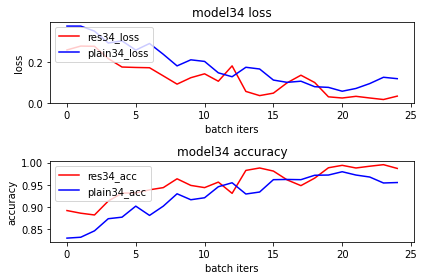

In [80]:
# summarize history for loss  
plt.subplot(211)  
plt.plot(history_res34.history['loss'],'r')  
plt.plot(history_plain34.history['loss'], 'b')  
plt.title('model34 loss')  
plt.ylabel('loss')  
plt.xlabel('batch iters')  
plt.legend(['res34_loss', 'plain34_loss'], loc='upper left')  

# summarize history for accuracy  
plt.subplot(212)  
plt.plot(history_res34.history['accuracy'], 'r')  
plt.plot(history_plain34.history['accuracy'], 'b')  
plt.title('model34 accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('batch iters')  
plt.legend(['res34_acc', 'plain34_acc'], loc='upper left')  
    
plt.tight_layout()

plt.show()

# 05. ResNet-50 vs Plain-50

In [83]:
# ResNet-50

# batch size = 16 조정
res_50.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9),
    metrics=['accuracy'])

history_res50 = res_50.fit(
    train_data_gen,
    epochs=epochs,
    validation_data=val_data_gen)


Epoch 1/25
125/125 [==============================] - 295s 2s/step - loss: 0.7968 - accuracy: 0.5400 - val_loss: 0.8444 - val_accuracy: 0.5000
Epoch 2/25
125/125 [==============================] - 283s 2s/step - loss: 0.6803 - accuracy: 0.5940 - val_loss: 1.0335 - val_accuracy: 0.5000
Epoch 3/25
125/125 [==============================] - 284s 2s/step - loss: 0.6563 - accuracy: 0.6155 - val_loss: 0.7008 - val_accuracy: 0.5540
Epoch 4/25
125/125 [==============================] - 284s 2s/step - loss: 0.6489 - accuracy: 0.6315 - val_loss: 0.6126 - val_accuracy: 0.6650
Epoch 5/25
125/125 [==============================] - 283s 2s/step - loss: 0.6243 - accuracy: 0.6380 - val_loss: 0.6137 - val_accuracy: 0.6680
Epoch 6/25
125/125 [==============================] - 283s 2s/step - loss: 0.6105 - accuracy: 0.6585 - val_loss: 0.6325 - val_accuracy: 0.6660
Epoch 7/25
125/125 [==============================] - 284s 2s/step - loss: 0.5946 - accuracy: 0.6800 - val_loss: 0.6984 - val_accuracy: 0.6250

In [85]:
# plain 50

plain_50.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9),
    metrics=['accuracy'])

history_plain50 = plain_50.fit(
    train_data_gen,
    epochs=epochs,
    validation_data=val_data_gen)


Epoch 1/25
125/125 [==============================] - 234s 2s/step - loss: 0.6712 - accuracy: 0.5805 - val_loss: 0.7028 - val_accuracy: 0.5790
Epoch 2/25
125/125 [==============================] - 230s 2s/step - loss: 0.6684 - accuracy: 0.5820 - val_loss: 0.6751 - val_accuracy: 0.5830
Epoch 3/25
125/125 [==============================] - 229s 2s/step - loss: 0.6757 - accuracy: 0.5705 - val_loss: 0.6545 - val_accuracy: 0.6110
Epoch 4/25
125/125 [==============================] - 229s 2s/step - loss: 0.6628 - accuracy: 0.5910 - val_loss: 0.6465 - val_accuracy: 0.6280
Epoch 5/25
125/125 [==============================] - 230s 2s/step - loss: 0.6580 - accuracy: 0.5970 - val_loss: 0.6601 - val_accuracy: 0.6170
Epoch 6/25
125/125 [==============================] - 230s 2s/step - loss: 0.6587 - accuracy: 0.5945 - val_loss: 0.6637 - val_accuracy: 0.6010
Epoch 7/25
125/125 [==============================] - 230s 2s/step - loss: 0.6522 - accuracy: 0.6185 - val_loss: 0.6795 - val_accuracy: 0.6220

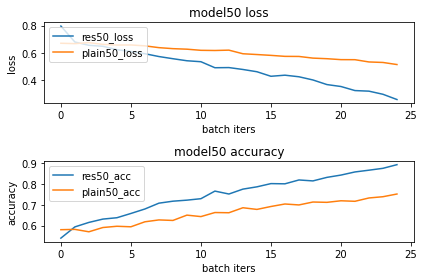

In [89]:
# summarize history for loss  
plt.subplot(211)  
plt.plot(history_res50.history['loss'])  
plt.plot(history_plain50.history['loss'])  
plt.title('model50 loss')  
plt.ylabel('loss')  
plt.xlabel('batch iters')  
plt.legend(['res50_loss', 'plain50_loss'], loc='upper left')  

# summarize history for accuracy  
plt.subplot(212)  
plt.plot(history_res50.history['accuracy'])  
plt.plot(history_plain50.history['accuracy'])  
plt.title('model50 accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('batch iters')  
plt.legend(['res50_acc', 'plain50_acc'], loc='upper left')  
    
plt.tight_layout()

plt.show()

||ResNet | Plain|
|---|---|---|
|layer 34| 0.6327 | 0.7667 |
|layer 50| 0.5375 | 0.6029 |

위 표는 각각 layer 갯수 34개와 50개 에서의 ResNet 사용했을 때와 사용하지않았을 때의 validation dataset에 대한 최저 loss입니다.\
4번의 학습 전부 epoch는 25로 주어졌고 validation loss 표를 확인해봤을 때 최저 loss 값은 layer에 상관없이 ResNet을 사용했을 때 더 낮았습니다.

또한 그래프를 확인 해봐도 ResNet을 사용했을 때의 loss가 Plain보다 낮게 형성되어있고, 정확도 또한 더 좋은 것으로 확인됩니다.

# 회고

ResNet identity block의 shape을 맞춰주는 데에 어려움을 느꼈습니다.\
Res34의 경우 현재 channel과 들어온 x값의 크기가 다를 경우 1x1 conv layer를 통해 reshape 시켜줄 수 있었고,\
Res50같은 경우 현재 channel 크기와 들어오는 residual의 크기가 항상 달랐습니다.\
그래서 channel에 4를 곱해준 값과 크기가 같은 경우 같은 블럭안에서 돌기 때문에 현재 channel*4의 shape과 다를 경우만\
convolution layer에 넣어주어 크기를 맞춰 주었습니다.